In [1]:
import sys
sys.path.append('../../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_array, UniformPrior,
                   get_dataset_psd, get_dataset_peaks, load_posterior, simulator_hnn,
                   get_parameter_recovery, get_posterior_predictive_check, hnn_beta_param_function)
from hnn_core import jones_2009_model
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
rng_seed = 123

scale_factor = 60_000

sns.set()
sns.set_style("white")

device = 'cpu'

sim_type = 'hnn_beta'
data_path = f'../../data/{sim_type}'

with open(f'{data_path}/posteriors/posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
zero_samples = posterior_metadata['zero_samples'] 

net = jones_2009_model()

simulator = partial(simulator_hnn, prior_dict=prior_dict, param_function=hnn_beta_param_function,
                    network_model=net, tstop=tstop, return_objects=True)

/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


In [2]:
# Values on [0,1] mapped to range of bounds defined in prior_dict
theta_cond_list = [np.array([0.25, 0.5, 0.99, 0.99]), np.array([0.75, 0.5, 0.75, 0.75])]


x_cond_list, theta_dict_list, net_list = list(), list(), list()
prox_times_list, dist_times_list = list(), list()
for theta_cond in theta_cond_list:
    theta_dict = {param_name: param_dict['rescale_function'](theta_cond[idx], param_dict['bounds']) for 
                  idx, (param_name, param_dict) in enumerate(prior_dict.items())}

    net, dpl = simulator(torch.tensor(theta_cond).float())[0]
    x_cond = dpl[0].copy().smooth(20).data['agg']
        
    theta_dict_list.append(theta_dict)
    x_cond_list.append(x_cond)
    net_list.append(net)
    
    net_idx = 0
    spike_times = np.array(net.cell_response.spike_times)
    spike_types = np.array(net.cell_response.spike_types)
    prox_times = spike_times[spike_types == 'beta_prox']
    dist_times = spike_times[spike_types == 'beta_dist']
    
    prox_times_list.append(prox_times)
    dist_times_list.append(dist_times)



{'dist_var': 2.5, 'prox_var': 20.0, 'dist_exc': 9.77237242415122e-06, 'prox_exc': 9.77237242415122e-06}
joblib will run over 1 jobs
Loading custom mechanism files from /home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.5 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 200.0 ms...
Simulation time: 210.0 ms...
Simulation time: 220.0 ms...
Simulation time

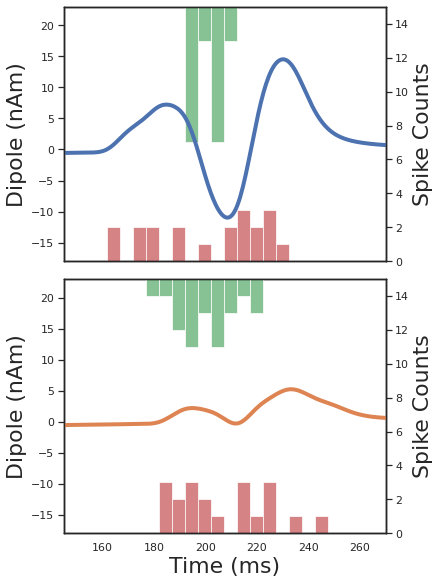

In [76]:
%matplotlib inline
bins = np.linspace(0,tstop,100)

labelsize = 22
titlesize=22

offset_samples = 0

waveform_ylim = [-18, 23]
hist_ylim = [0, 15]
# Plot conditioning features    
t_vec = np.linspace(0, tstop, x_cond_list[0].squeeze().shape[0])

time_lim = [145, 270]

fig, axes = plt.subplots(2,1,figsize=(6,8), constrained_layout=True, sharex=True)

# Top panel
axes[0].set_ylabel('Dipole (nAm)', fontsize=labelsize)
axes[0].set_ylim(waveform_ylim)
ax_top_prox = axes[0].twinx()
ax_top_prox.set_ylim(hist_ylim)
ax_top_dist = axes[0].twinx()
ax_top_dist.set_ylim(hist_ylim)
ax_top_waveform = axes[0].twinx()
ax_top_waveform.set_ylim(waveform_ylim)
ax_top_prox.hist(prox_times_list[0], color='C3', label='Proximal', bins=bins, alpha=0.7)
ax_top_dist.hist(dist_times_list[0], color='C2', label='Distal', bins=bins, alpha=0.7)
ax_top_dist.set_ylim(hist_ylim[-1], hist_ylim[0])

ax_top_prox.set_ylabel('Spike Counts', fontsize=labelsize)
ax_top_dist.set_yticklabels('')
ax_top_waveform.set_yticklabels('')
ax_top_dist.set_yticks([])
ax_top_waveform.set_yticks([])

ax_top_waveform.plot(plot_t_vec, x_cond_list[0].squeeze() * scale_factor, linewidth=4,
             color='C0')
#axes[0].set_title('Condition 1', fontsize=titlesize)

# Bottom Panel
axes[1].set_ylabel('Dipole (nAm)', fontsize=labelsize)
axes[1].set_ylim(waveform_ylim)
ax_bottom_prox = axes[1].twinx()
ax_bottom_prox.set_ylim(hist_ylim)
ax_bottom_dist = axes[1].twinx()
ax_bottom_dist.set_ylim(hist_ylim)
ax_bottom_waveform = axes[1].twinx()
ax_bottom_waveform.set_ylim(waveform_ylim)
ax_bottom_prox.hist(prox_times_list[1], color='C3', label='Proximal', bins=bins, alpha=0.7)
ax_bottom_dist.hist(dist_times_list[1], color='C2', label='Distal', bins=bins, alpha=0.7)
ax_bottom_dist.set_ylim(hist_ylim[-1], hist_ylim[0])

ax_bottom_prox.set_ylabel('Spike Counts', fontsize=labelsize)
ax_bottom_dist.set_yticklabels('')
ax_bottom_waveform.set_yticklabels('')
ax_bottom_dist.set_yticks([])
ax_bottom_waveform.set_yticks([])

ax_bottom_waveform.plot(plot_t_vec, x_cond_list[1].squeeze() * scale_factor, linewidth=4,
             color='C1')
axes[1].set_xlabel('Time (ms)', fontsize=labelsize)
#axes[1].set_title('Condition 2', fontsize=titlesize)


axes[0].set_xlim(time_lim)

plt.savefig('hnn_beta_cond_inputs.svg')